In [1]:
from md_intrinsic_dimension import intrinsic_dimension, section_id, secondary_structure_id
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import seaborn as sns
import logging
from moleculekit.molecule import Molecule
from itertools import product

## Villin

In [ ]:
#ESTIMATORS BENCHMARK

#estimators = ['CorrInt', 'DANCo', 'ESS', 'FisherS','KNN', 'lPCA', 'MADA', 'MiND_ML', 'MLE', 'MOM', 'TLE', 'TwoNN']
#estimators = ['CorrInt', 'DANCo', 'ESS', 'KNN', 'lPCA', 'MADA', 'MLE', 'MOM', 'TLE', 'TwoNN']
estimators = ['CorrInt','lPCA', 'MADA', 'MLE', 'MOM', 'TLE', 'TwoNN']
states = [2, 1]  # trajectory indices
colors = plt.cm.tab10(np.linspace(0, 1, len(states)))  # one color per state
projection_method = 'Distances'  # or 'Distances'
projection_kwargs = {'skip': 3}

n_estimators = len(estimators)
ncols = 3
fig, ax = plt.subplots(nrows=n_estimators, ncols=ncols, figsize=(15, 5*n_estimators), sharey=False)
ax = np.atleast_2d(ax)

line_handles, line_labels = None, None 

for est_idx, estimator in enumerate(estimators):
    state_ids = []
    means = []
    for state_idx, state in enumerate(states):
        # Compute intrinsic dimension
        mean_all, mean_last, local_id = intrinsic_dimension(topology='examples/villin/2F4K.pdb', trajectory=f'examples/villin/2F4K_{state}.xtc', projection_method=projection_method, projection_kwargs = projection_kwargs,id_method='local',id_kwargs={'estimator': estimator}, verbose=True)
        state_ids.append(local_id)
        means.append(mean_all)
        frames = np.arange(len(local_id))

        # Column 1: instantaneous ID 
        line, = ax[est_idx, 0].plot(frames, local_id, color=colors[state_idx], lw=0.8, label=state)
        if est_idx == 0:  # grab legend handles only once
            if line_handles is None:
                line_handles, line_labels = [], []
            line_handles.append(line)
            line_labels.append(f"State {state}")
    ax[est_idx, 0].set_ylim(0, 50)
    ax[est_idx, 0].set_ylabel("Local ID")
    if est_idx == n_estimators - 1:
        ax[est_idx, 0].set_xlabel("Frames")

    # Column 2: histogram of instantaneous ID
    all_values = np.concatenate(state_ids)
    bins = np.linspace(all_values.min(), all_values.max(), 30)
    for state_idx, local_id in enumerate(state_ids):
        ax[est_idx, 1].hist(local_id, bins=bins, alpha=0.7, color=colors[state_idx],
                              edgecolor='black', linewidth=0.5)
    ax[est_idx, 1].set_xlim(0, 50)
    #ax[est_idx, 1].set_ylim(0, 600)
    ax[est_idx, 1].set_title(estimator)
    ax[est_idx, 1].set_ylabel("Frequency")
    if est_idx == n_estimators - 1:
        ax[est_idx, 1].set_xlabel("Local ID")

    # Column 3: boxplot of local ID per state
    bp = ax[est_idx, 2].boxplot(
        state_ids,
        labels=[f"{s}" for s in states],patch_artist=True, showmeans=True,meanprops=dict(marker='*',markerfacecolor='white',markeredgecolor='black', markersize=6))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
        patch.set_edgecolor('black')
    for median in bp['medians']:
        median.set_color('black')
    ax[est_idx, 2].set_ylim(0, 50)
    #ax[est_idx, 2].set_xlabel("Boxplot")
    ax[est_idx, 2].set_ylabel("Local ID")  


fig.legend(line_handles, line_labels, title="Trajectory", loc="center left", bbox_to_anchor=(-0.1, 0.5))
plt.tight_layout(rect=[0, 0, 0.95, 0.95])

plt.savefig(f'../bin/villin_benchmark_{projection_method}.png', dpi=300, bbox_inches='tight')
plt.show()


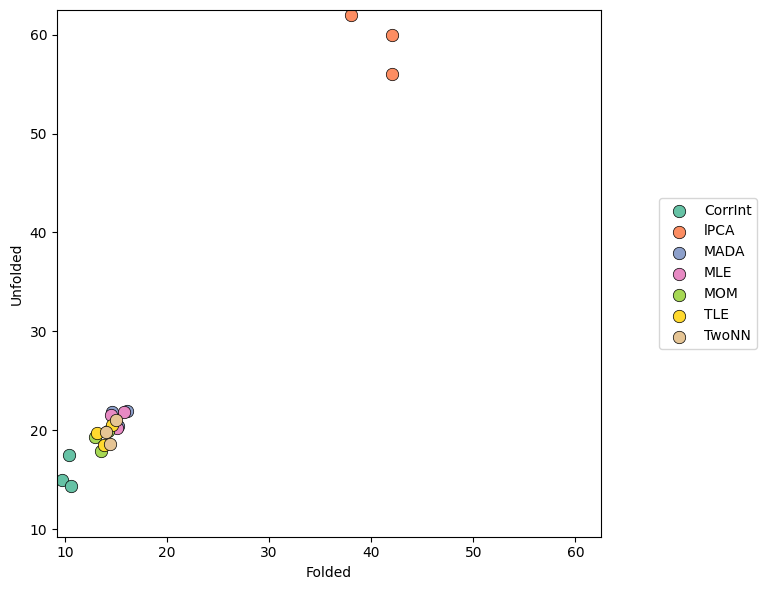

In [ ]:
#SCATTER ALL ESTIMATORS ????

#estimators = ['CorrInt', 'DANCo', 'ESS', 'FisherS','KNN', 'lPCA', 'MADA', 'MiND_ML', 'MLE', 'MOM', 'TLE', 'TwoNN']
#estimators = ['CorrInt', 'DANCo', 'ESS', 'KNN', 'lPCA', 'MADA', 'MLE', 'MOM', 'TLE', 'TwoNN']
estimators = ['CorrInt','lPCA', 'MADA', 'MLE', 'MOM', 'TLE', 'TwoNN']
#estimators = ['TwoNN', 'TwoNN']
states = [0,1,2,3,4,5]  # trajectory indices
#colors = plt.cm.tab10(np.linspace(0, 1, len(states)))  # one color per state
projection_method = 'Dihedrals'  # or 'Distances'
projection_kwargs = {'skip': 3}

cmap = plt.get_cmap('Set2') 
data = []

for estimator, state in product(estimators, states):
	mean_all, mean_last = intrinsic_dimension(topology='examples/villin/2F4K.pdb', trajectory=f'examples/villin/2F4K_{state}.xtc', projection_method=projection_method, projection_kwargs = projection_kwargs,id_method='global',id_kwargs={'estimator': estimator}, verbose=False)
	data.append({'trajectory': state,
	  'estimator': estimator,
	  'mean_all': mean_all,
	  'mean_last': mean_last})
data = pd.DataFrame(data)
data['folded'] = data['trajectory'] % 2 != 0
mark = {True: 'o', False: 's'} #DA RISOLVERE

plt.figure(figsize=(8,6))
group=data.groupby('trajectory')

for i, estimator in enumerate(estimators):
    estimator_data = data[data['estimator'] == estimator]
    folded_values = estimator_data[estimator_data['folded']]['mean_all']
    unfolded_values = estimator_data[~estimator_data['folded']]['mean_all']

    plt.scatter(folded_values, unfolded_values, label=estimator,color=cmap(i),marker='o',edgecolor='black',linewidth=0.5,s=80)

min_val = data['mean_all'].min() - 0.5
max_val = data['mean_all'].max() + 0.5
#plt.axline((min_val, min_val), (max_val, max_val), lw=0.5, color='black', alpha=0.8)

plt.xlabel('Folded')
plt.ylabel('Unfolded')
plt.legend(bbox_to_anchor=(1.3, 0.5), loc='center right')

# Set equal axis limits for better visualization
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

plt.tight_layout()
plt.savefig('../bin/villin_foldedvsunfolded.png', dpi=300, bbox_inches='tight')
plt.show()


In [2]:
data = []
states = [0,1,2,3,4,5] 
estimators = ['CorrInt','lPCA', 'MADA', 'MLE', 'MOM', 'TLE', 'TwoNN']
projection_method = 'Dihedrals'  # or 'Distances'
projection_kwargs = {'skip': 3}

for estimator, state in product(estimators, states):
	mean_all, mean_last, local_id = intrinsic_dimension(topology='examples/villin/2F4K.pdb', trajectory=f'examples/villin/2F4K_{state}.xtc', projection_method=projection_method, projection_kwargs = projection_kwargs,id_method='local',id_kwargs={'estimator': estimator}, verbose=False)
	data.append({'trajectory': state,
	  'estimator': estimator,
	  'mean_all': mean_all,
	  'mean_last': mean_last,
      'local_id': local_id})
data = pd.DataFrame(data)
data['folded'] = data['trajectory'] % 2 != 0

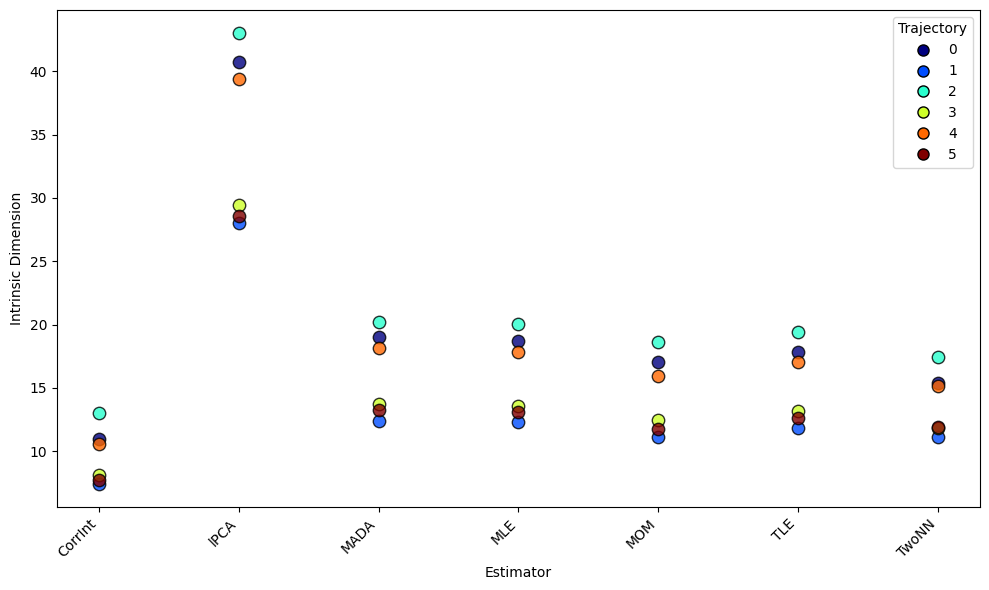

In [ ]:
estimators = data["estimator"].unique()
states = data["trajectory"].unique()   # or sorted unique trajectory IDs
colors = plt.cm.jet(np.linspace(0, 1, len(states)))
fig, ax = plt.subplots(figsize=(10,6))
color_map = dict(zip(states, colors))

for est_idx, est in enumerate(estimators):
    subset = data[data["estimator"] == est]
    for _, row in subset.iterrows():
        ax.scatter(est_idx, row["mean_all"],color=color_map[row["trajectory"]],edgecolor="black", alpha=0.8, s=80)

ax.set_xticks(range(len(estimators)))
ax.set_xticklabels(estimators, rotation=45, ha="right")
ax.set_ylabel("Intrinsic Dimension")
ax.set_xlabel("Estimator")
handles = [
    plt.Line2D([0],[0], marker="o", color="w", label= s,
               markerfacecolor=color_map[s], markersize=8, markeredgecolor='black')
    for s in states
]
ax.legend(handles=handles, title="Trajectory")

plt.tight_layout()
plt.savefig('../bin/villin_scatter_est_id.png', dpi=300, bbox_inches='tight')
plt.show()


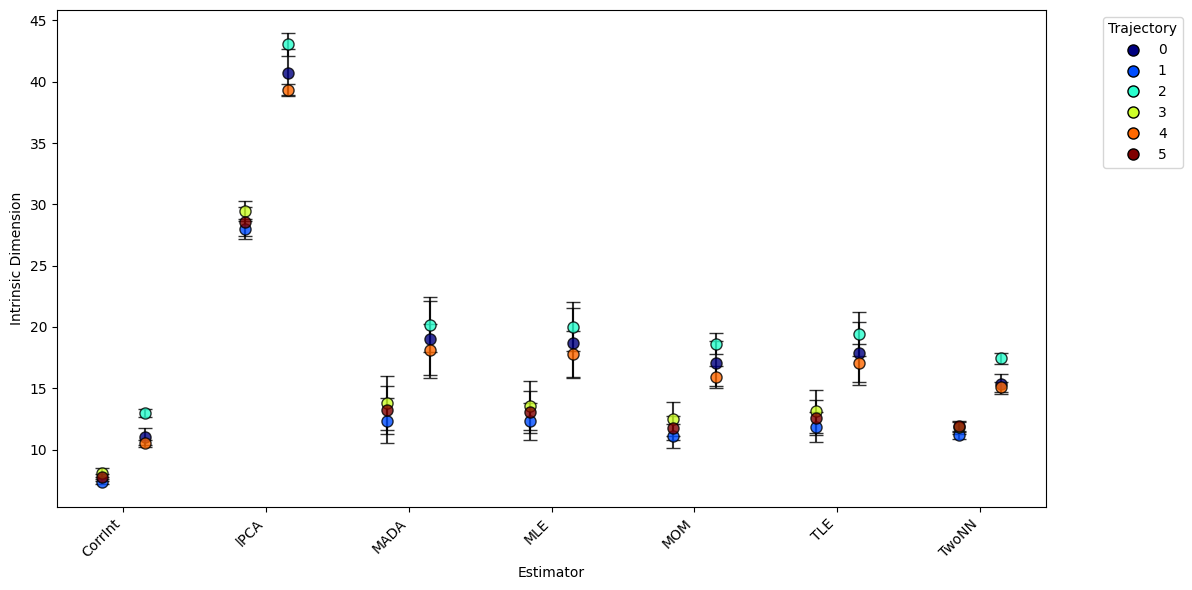

In [ ]:
#mstd deviation

estimators = data["estimator"].unique()
states = data["trajectory"].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(states)))
color_map = dict(zip(states, colors))

fig, ax = plt.subplots(figsize=(12,6))

for i, row in data.iterrows():
    est_idx = np.where(estimators == row["estimator"])[0][0]
    # small offset to separate folded/unfolded visually
    offset = -0.15 if row["folded"] else 0.15
    x = est_idx + offset
    mean_val = row["mean_all"]
    local_vals = row["local_id"]
    std_val = np.std(local_vals)
    
    ax.errorbar(
        x, mean_val,yerr=std_val,fmt='o',color=color_map[row["trajectory"]],ecolor='black',capsize=5, markersize=8, markeredgecolor='black', alpha=0.8)

ax.set_xticks(range(len(estimators)))
ax.set_xticklabels(estimators, rotation=45, ha='right')
ax.set_ylabel("Intrinsic Dimension")
ax.set_xlabel("Estimator")
handles = [plt.Line2D([0],[0], marker='o', color='w', markerfacecolor=color_map[s],markeredgecolor='black', markersize=8,label=f'{s}') for s in states]
ax.legend(handles=handles, title='Trajectory', bbox_to_anchor=(1.05,1), loc='upper left')

plt.tight_layout()
plt.savefig('../bin/villin_scatter_est_id_std.png', dpi=300, bbox_inches='tight')
plt.show()

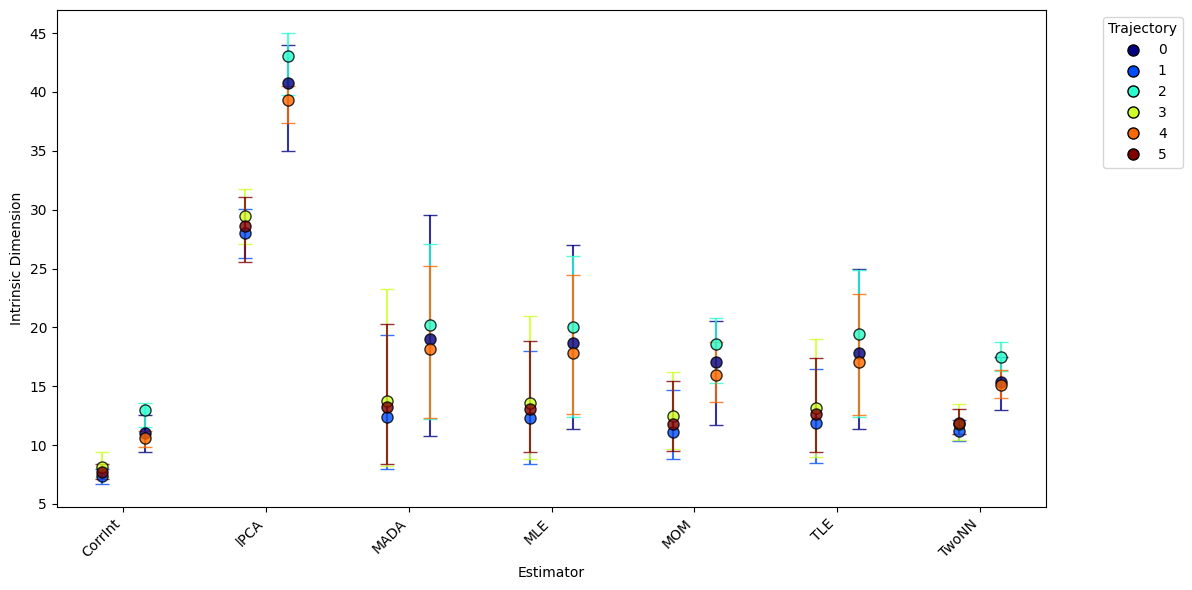

In [ ]:
#min max deviation

estimators = data["estimator"].unique()
states = data["trajectory"].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(states)))
color_map = dict(zip(states, colors))

fig, ax = plt.subplots(figsize=(12,6))

for i, row in data.iterrows():
    est_idx = np.where(estimators == row["estimator"])[0][0]
    # small offset to separate folded/unfolded visually
    offset = -0.15 if row["folded"] else 0.15
    x = est_idx + offset
    mean_val = row["mean_all"]
    local_vals = row["local_id"]
    ymin, ymax = np.min(local_vals), np.max(local_vals)
    
    ax.errorbar(
        x, mean_val,yerr=[[mean_val - ymin], [ymax - mean_val]],fmt='o',color=color_map[row["trajectory"]],ecolor=color_map[row["trajectory"]],capsize=5, markersize=8, markeredgecolor='black', alpha=0.8)

ax.set_xticks(range(len(estimators)))
ax.set_xticklabels(estimators, rotation=45, ha='right')
ax.set_ylabel("Intrinsic Dimension")
ax.set_xlabel("Estimator")
handles = [plt.Line2D([0],[0], marker='o', color='w', markerfacecolor=color_map[s],markeredgecolor='black', markersize=8,label=f'{s}') for s in states]
ax.legend(handles=handles, title='Trajectory', bbox_to_anchor=(1.05,1), loc='upper left')

plt.tight_layout()
plt.savefig('../bin/villin_scatter_est_id_minmax.png', dpi=300, bbox_inches='tight')
plt.show()

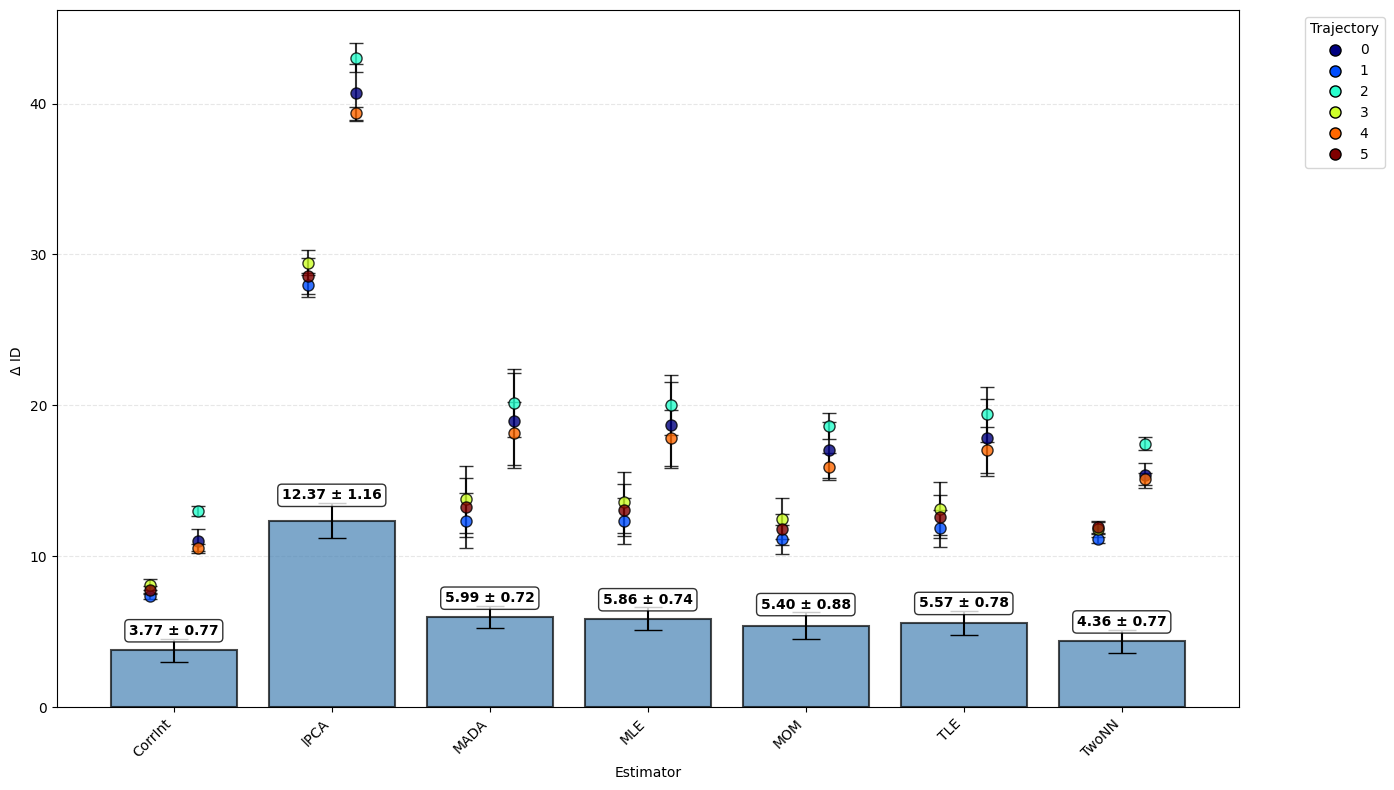

In [3]:
delta_stats = []

for estimator in data['estimator'].unique():
    estimator_data = data[data['estimator'] == estimator]
    
    # Get means for each group
    folded_mean = estimator_data[estimator_data['folded']]['mean_all'].mean()
    unfolded_mean = estimator_data[~estimator_data['folded']]['mean_all'].mean()
    delta = abs(folded_mean - unfolded_mean)
    
    # Calculate standard errors for each group
    folded_std = estimator_data[estimator_data['folded']]['mean_all'].std()
    unfolded_std = estimator_data[~estimator_data['folded']]['mean_all'].std()
    folded_count = estimator_data[estimator_data['folded']]['mean_all'].count()
    unfolded_count = estimator_data[~estimator_data['folded']]['mean_all'].count()
    
    folded_sem = folded_std / np.sqrt(folded_count)
    unfolded_sem = unfolded_std / np.sqrt(unfolded_count)
    
    # Standard error of the difference (assuming independent groups)
    delta_sem = np.sqrt(folded_sem**2 + unfolded_sem**2)
    
    delta_stats.append({
        'estimator': estimator,
        'delta': delta,
        'delta_sem': delta_sem,
        'folded_mean': folded_mean,
        'unfolded_mean': unfolded_mean,
        'folded_sem': folded_sem,
        'unfolded_sem': unfolded_sem
    })

delta_df = pd.DataFrame(delta_stats)

# Get your original color scheme for individual points
estimators = data["estimator"].unique()
states = data["trajectory"].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(states)))
color_map = dict(zip(states, colors))

fig, ax = plt.subplots(figsize=(14, 8))

# Plot the delta bars with error bars
bars = ax.bar(range(len(delta_df)), delta_df['delta'], 
              yerr=delta_df['delta_sem'], capsize=10,
              color='steelblue', alpha=0.7, edgecolor='black', linewidth=1.5)


for i, row in data.iterrows():
    est_idx = np.where(estimators == row["estimator"])[0][0]
    # small offset to separate folded/unfolded visually
    offset = -0.15 if row["folded"] else 0.15
    x = est_idx + offset
    mean_val = row["mean_all"]
    local_vals = row["local_id"]
    std_val = np.std(local_vals)
    
    # YOUR ORIGINAL ERROR BAR CODE
    ax.errorbar(
        x, mean_val, yerr=std_val, fmt='o', 
        color=color_map[row["trajectory"]], ecolor='black', 
        capsize=5, markersize=8, markeredgecolor='black', alpha=0.8
    )

# Add delta value labels
for i, (delta, sem) in enumerate(zip(delta_df['delta'], delta_df['delta_sem'])):
    ax.text(i, delta + sem + 0.05, f'{delta:.2f} ± {sem:.2f}', 
            ha='center', va='bottom', fontweight='bold', fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

ax.set_xticks(range(len(delta_df)))
ax.set_xticklabels(delta_df['estimator'], rotation=45, ha='right')
ax.set_ylabel("Δ ID ")
ax.set_xlabel("Estimator")

# Add your original trajectory legend
handles = [plt.Line2D([0],[0], marker='o', color='w', 
                     markerfacecolor=color_map[s], markeredgecolor='black', 
                     markersize=8, label=f'{s}') for s in states]
ax.legend(handles=handles, title='Trajectory', bbox_to_anchor=(1.05,1), loc='upper left')

# Add grid and improve appearance
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('../bin/villin_delta_with_variability.png', dpi=300, bbox_inches='tight')
plt.show()

## NTL9

In [ ]:
#ESTIMATORS BENCHMAKR

#estimators = ['CorrInt', 'DANCo', 'ESS', 'FisherS','KNN', 'lPCA', 'MADA', 'MiND_ML', 'MLE', 'MOM', 'TLE', 'TwoNN']
#estimators = ['CorrInt', 'DANCo', 'ESS', 'KNN', 'lPCA', 'MADA', 'MLE', 'MOM', 'TLE', 'TwoNN']
estimators = ['CorrInt', 'KNN', 'lPCA', 'MADA', 'MLE', 'MOM', 'TLE', 'TwoNN']

states = [2, 1]  # trajectory indices
colors = plt.cm.tab10(np.linspace(0, 1, len(states)))  
projection_method = 'Distances' 
projection_kwargs = {'skip':3}
n_estimators = len(estimators)
ncols = 3
fig, ax = plt.subplots(nrows=n_estimators, ncols=ncols, figsize=(15, 5*n_estimators), sharey=False)
ax = np.atleast_2d(ax)

line_handles, line_labels = None, None 

for est_idx, estimator in enumerate(estimators):
    state_ids = []
    means = []
    for state_idx, state in enumerate(states):
        # Compute intrinsic dimension
        mean_all, mean_last, local_id = intrinsic_dimension(topology='examples/NTL9/NTL9.pdb', trajectory=f'examples/NTL9/NTL9_{state}.xtc', projection_method=projection_method, projection_kwargs = projection_kwargs, id_method='local',id_kwargs={'estimator': estimator}, verbose=False)
        state_ids.append(local_id)
        means.append(mean_all)
        frames = np.arange(len(local_id))

        # Column 1: instantaneous ID 
        line, = ax[est_idx, 0].plot(frames, local_id, color=colors[state_idx], lw=0.8, label=state)
        if est_idx == 0:  # grab legend handles only once
            if line_handles is None:
                line_handles, line_labels = [], []
            line_handles.append(line)
            line_labels.append(f'State {state}')
    ax[est_idx, 0].set_ylim(0, 50)
    ax[est_idx, 0].set_ylabel('Local ID')
    if est_idx == n_estimators - 1:
        ax[est_idx, 0].set_xlabel('Frames')

    # Column 2: histogram of instantaneous ID
    all_values = np.concatenate(state_ids)
    bins = np.linspace(all_values.min(), all_values.max(), 30)
    for state_idx, local_id in enumerate(state_ids):
        ax[est_idx, 1].hist(local_id, bins=bins, alpha=0.7, color=colors[state_idx],
                              edgecolor='black', linewidth=0.5)
    ax[est_idx, 1].set_xlim(0, 50)
    ax[est_idx, 1].set_title(estimator)
    ax[est_idx, 1].set_ylabel('Frequency')
    if est_idx == n_estimators - 1:
        ax[est_idx, 1].set_xlabel('Local ID')

    # Column 3: boxplot of local ID per state
    bp = ax[est_idx, 2].boxplot(
        state_ids,
        labels=[f'{s}' for s in states],patch_artist=True, showmeans=True,meanprops=dict(marker='*',markerfacecolor='white',markeredgecolor='black', markersize=6))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
        patch.set_edgecolor('black')

    for median in bp['medians']:
        median.set_color('black')
    ax[est_idx, 2].set_ylim(0, 50)
    #ax[est_idx, 2].set_xlabel('Boxplot')
    ax[est_idx, 2].set_ylabel('Local ID')  


fig.legend(line_handles, line_labels, title='Trajectory', loc='center left', bbox_to_anchor=(-0.1, 0.5))
plt.tight_layout(rect=[0, 0, 0.95, 0.95])
plt.savefig(f'../bin/NTL9_benchmark_{projection_method}.png', dpi=300, bbox_inches='tight')
plt.show()


In [13]:
#COMPUTE ID
states = [0,1,2,3,4,5]  # trajectory indices
#colors = plt.cm.tab10(np.linspace(0, 1, len(states)))  # one color per state
projection_method = 'Dihedrals'  # or 'Distances'
projection_kwargs = {'skip': 3}

cmap = plt.get_cmap('Set2') 
data = []

for estimator, state in product(estimators, states):
	mean_all, mean_last, local_id = intrinsic_dimension(topology='examples/NTL9/NTL9.pdb', trajectory=f'examples/NTL9/NTL9_{state}.xtc', projection_method=projection_method, projection_kwargs = projection_kwargs,id_method='local',id_kwargs={'estimator': estimator}, verbose=False)
	data.append({'trajectory': state,
	  'estimator': estimator,
	  'mean_all': mean_all,
	  'mean_last': mean_last,
      'local_id': local_id})
data = pd.DataFrame(data)
data['folded'] = data['trajectory'] % 2 != 0

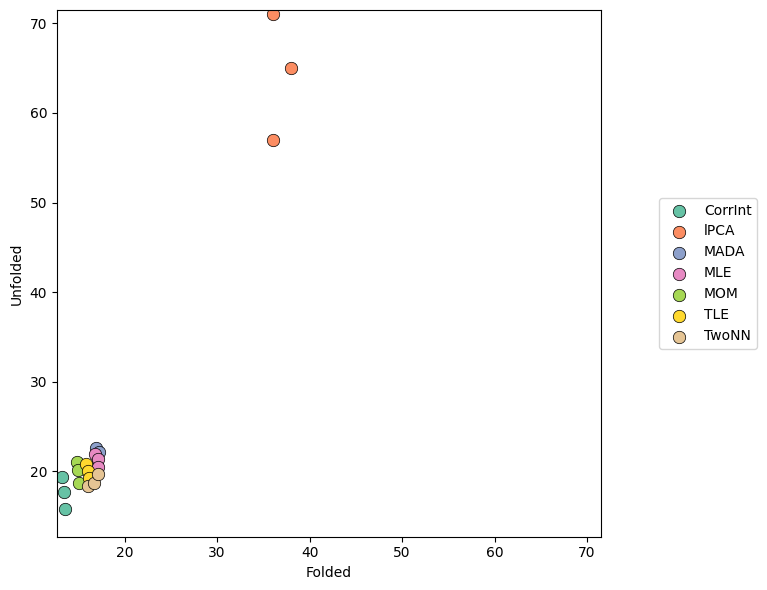

In [6]:

plt.figure(figsize=(8,6))
group=data.groupby('trajectory')

for i, estimator in enumerate(estimators):
    estimator_data = data[data['estimator'] == estimator]
    folded_values = estimator_data[estimator_data['folded']]['mean_all']
    unfolded_values = estimator_data[~estimator_data['folded']]['mean_all']

    plt.scatter(folded_values, unfolded_values, label=estimator,color=cmap(i),marker='o',edgecolor='black',linewidth=0.5,s=80)

min_val = data['mean_all'].min() - 0.5
max_val = data['mean_all'].max() + 0.5
#plt.axline((min_val, min_val), (max_val, max_val), lw=0.5, color='black', alpha=0.8)

plt.xlabel('Folded')
plt.ylabel('Unfolded')
plt.legend(bbox_to_anchor=(1.3, 0.5), loc='center right')

# Set equal axis limits for better visualization
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

plt.tight_layout()
plt.savefig('../bin/NTL9_foldedvsunfolded.png', dpi=300, bbox_inches='tight')
plt.show()


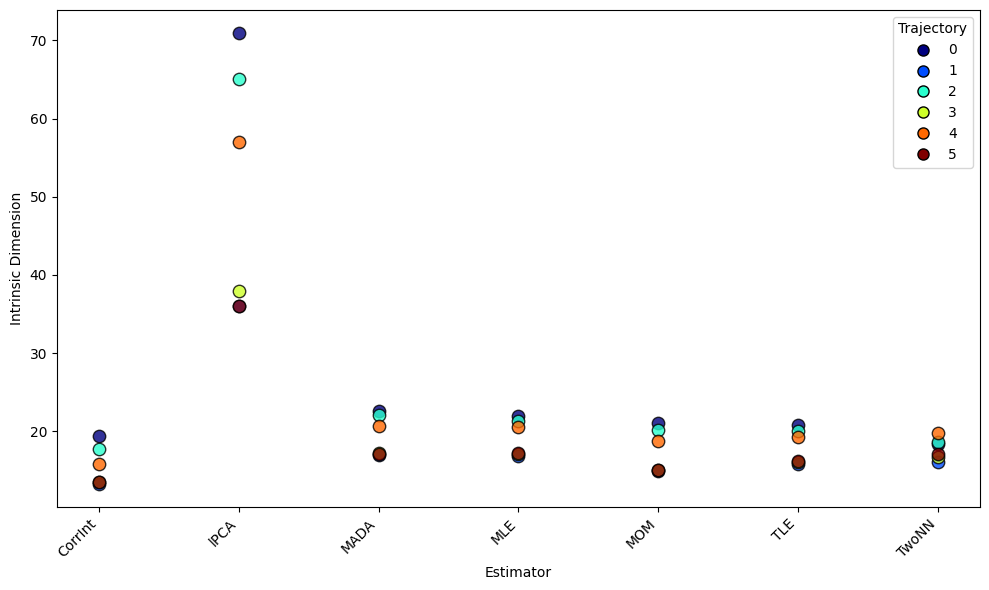

In [7]:
estimators = data["estimator"].unique()
states = data["trajectory"].unique()   # or sorted unique trajectory IDs
colors = plt.cm.jet(np.linspace(0, 1, len(states)))
fig, ax = plt.subplots(figsize=(10,6))
color_map = dict(zip(states, colors))

for est_idx, est in enumerate(estimators):
    subset = data[data["estimator"] == est]
    for _, row in subset.iterrows():
        ax.scatter(est_idx, row["mean_all"],color=color_map[row["trajectory"]],edgecolor="black", alpha=0.8, s=80)

ax.set_xticks(range(len(estimators)))
ax.set_xticklabels(estimators, rotation=45, ha="right")
ax.set_ylabel("Intrinsic Dimension")
ax.set_xlabel("Estimator")
handles = [
    plt.Line2D([0],[0], marker="o", color="w", label= s,
               markerfacecolor=color_map[s], markersize=8, markeredgecolor='black')
    for s in states
]
ax.legend(handles=handles, title="Trajectory")

plt.tight_layout()
plt.savefig('../bin/NTL9_scatter_est_id.png', dpi=300, bbox_inches='tight')
plt.show()


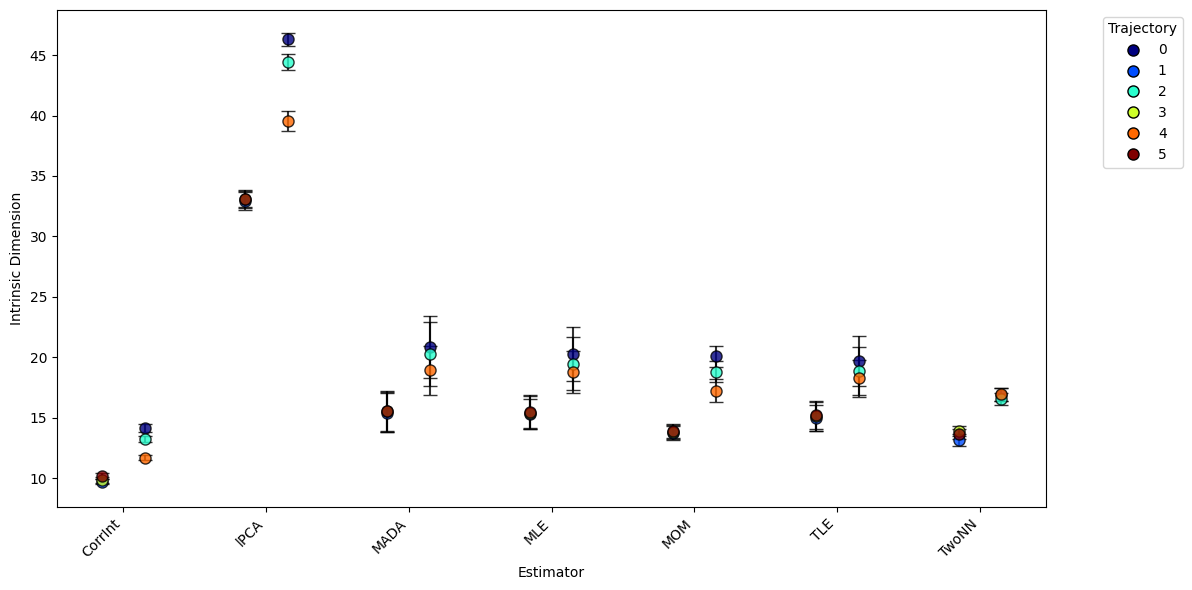

In [14]:
#mstd deviation

estimators = data["estimator"].unique()
states = data["trajectory"].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(states)))
color_map = dict(zip(states, colors))

fig, ax = plt.subplots(figsize=(12,6))

for i, row in data.iterrows():
    est_idx = np.where(estimators == row["estimator"])[0][0]
    # small offset to separate folded/unfolded visually
    offset = -0.15 if row["folded"] else 0.15
    x = est_idx + offset
    mean_val = row["mean_all"]
    local_vals = row["local_id"]
    std_val = np.std(local_vals)
    
    ax.errorbar(
        x, mean_val,yerr=std_val,fmt='o',color=color_map[row["trajectory"]],ecolor='black',capsize=5, markersize=8, markeredgecolor='black', alpha=0.8)

ax.set_xticks(range(len(estimators)))
ax.set_xticklabels(estimators, rotation=45, ha='right')
ax.set_ylabel("Intrinsic Dimension")
ax.set_xlabel("Estimator")
handles = [plt.Line2D([0],[0], marker='o', color='w', markerfacecolor=color_map[s],markeredgecolor='black', markersize=8,label=f'{s}') for s in states]
ax.legend(handles=handles, title='Trajectory', bbox_to_anchor=(1.05,1), loc='upper left')

plt.tight_layout()
plt.savefig('../bin/NTL9_scatter_est_id_std.png', dpi=300, bbox_inches='tight')
plt.show()

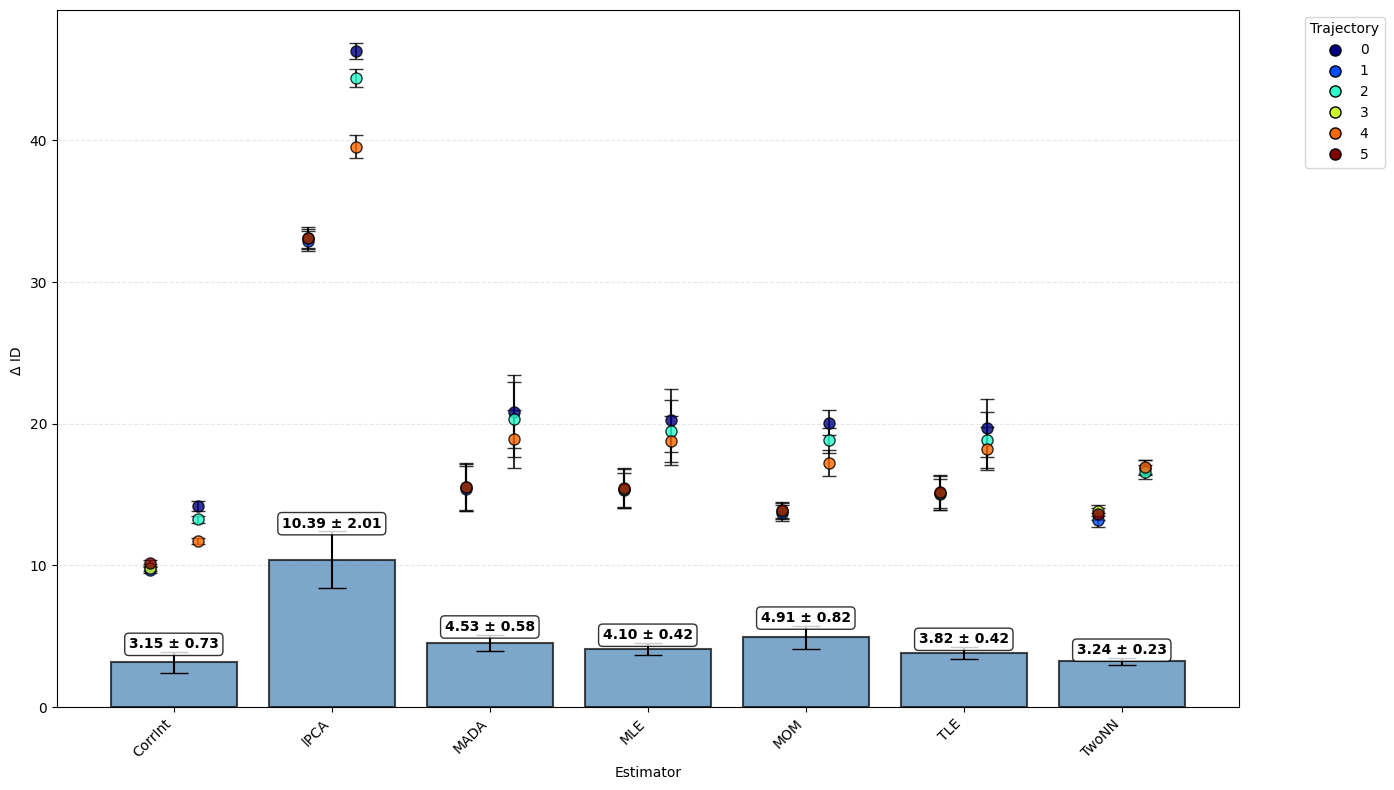

In [15]:
delta_stats = []

for estimator in data['estimator'].unique():
    estimator_data = data[data['estimator'] == estimator]
    
    # Get means for each group
    folded_mean = estimator_data[estimator_data['folded']]['mean_all'].mean()
    unfolded_mean = estimator_data[~estimator_data['folded']]['mean_all'].mean()
    delta = abs(folded_mean - unfolded_mean)
    
    # Calculate standard errors for each group
    folded_std = estimator_data[estimator_data['folded']]['mean_all'].std()
    unfolded_std = estimator_data[~estimator_data['folded']]['mean_all'].std()
    folded_count = estimator_data[estimator_data['folded']]['mean_all'].count()
    unfolded_count = estimator_data[~estimator_data['folded']]['mean_all'].count()
    
    folded_sem = folded_std / np.sqrt(folded_count)
    unfolded_sem = unfolded_std / np.sqrt(unfolded_count)
    
    # Standard error of the difference (assuming independent groups)
    delta_sem = np.sqrt(folded_sem**2 + unfolded_sem**2)
    
    delta_stats.append({
        'estimator': estimator,
        'delta': delta,
        'delta_sem': delta_sem,
        'folded_mean': folded_mean,
        'unfolded_mean': unfolded_mean,
        'folded_sem': folded_sem,
        'unfolded_sem': unfolded_sem
    })

delta_df = pd.DataFrame(delta_stats)

# Get your original color scheme for individual points
estimators = data["estimator"].unique()
states = data["trajectory"].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(states)))
color_map = dict(zip(states, colors))

fig, ax = plt.subplots(figsize=(14, 8))

# Plot the delta bars with error bars
bars = ax.bar(range(len(delta_df)), delta_df['delta'], 
              yerr=delta_df['delta_sem'], capsize=10,
              color='steelblue', alpha=0.7, edgecolor='black', linewidth=1.5)


for i, row in data.iterrows():
    est_idx = np.where(estimators == row["estimator"])[0][0]
    # small offset to separate folded/unfolded visually
    offset = -0.15 if row["folded"] else 0.15
    x = est_idx + offset
    mean_val = row["mean_all"]
    local_vals = row["local_id"]
    std_val = np.std(local_vals)
    
    # YOUR ORIGINAL ERROR BAR CODE
    ax.errorbar(
        x, mean_val, yerr=std_val, fmt='o', 
        color=color_map[row["trajectory"]], ecolor='black', 
        capsize=5, markersize=8, markeredgecolor='black', alpha=0.8
    )

# Add delta value labels
for i, (delta, sem) in enumerate(zip(delta_df['delta'], delta_df['delta_sem'])):
    ax.text(i, delta + sem + 0.05, f'{delta:.2f} ± {sem:.2f}', 
            ha='center', va='bottom', fontweight='bold', fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

ax.set_xticks(range(len(delta_df)))
ax.set_xticklabels(delta_df['estimator'], rotation=45, ha='right')
ax.set_ylabel("Δ ID ")
ax.set_xlabel("Estimator")

# Add your original trajectory legend
handles = [plt.Line2D([0],[0], marker='o', color='w', 
                     markerfacecolor=color_map[s], markeredgecolor='black', 
                     markersize=8, label=f'{s}') for s in states]
ax.legend(handles=handles, title='Trajectory', bbox_to_anchor=(1.05,1), loc='upper left')

# Add grid and improve appearance
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('../bin/NTL9_delta_with_variability.png', dpi=300, bbox_inches='tight')
plt.show()